# text2mel

## [seq] import

In [1]:
import json
import yaml
import sys
import time
import IPython.display as ipd
import pprint
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch
import torchaudio
from librosa.filters import mel as librosa_mel_fn
#import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from scipy.io.wavfile import write


import toybox

In [2]:
def plot_audio(audio, samplerate, title='time-domain waveform'):
    """
    usage:
        # audio is [channel, time(num_frames)] ex.torch.Size([1, 68608])
        # audio[0,:]: list of 1ch audio data
        # audio.shape[1]: int value of 1ch audio data length
        audio, sample_rate = torchaudio.load(str(iwav_path))
        %matplotlib inline
        plot_audio(audio, sample_rate)
    """
    # transform to mono
    channel = 0
    audio = audio[channel,:].view(1,-1)
    # to numpy
    audio = audio.to('cpu').detach().numpy().copy()
    time = np.linspace(0., audio.shape[1]/samplerate, audio.shape[1])
    
    fig, ax = plt.subplots(figsize=(12,9))
    
    ax.plot(time, audio[0, :])
    ax.set_title(title, fontsize=20, y=-0.12)
    ax.tick_params(direction='in')
    #ax.set_xlim(0, 3)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amp')
    #ax.legend()
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()
    #fig.savefig('figure.png')
    plt.close(fig)
    return fig

def plot_mel(tensors:list, titles:list[str]):
    """
    usage:
        mel = mel_process(...)
        fig_mel = plot_mel([mel_groundtruth[0], mel_prediction[0]],
                            ['groundtruth', 'inferenced(model)'])

    """
    xlim = max([t.shape[1] for t in tensors])
    fig, axs = plt.subplots(nrows=len(tensors),
                            ncols=1,
                            figsize=(12, 9),
                            constrained_layout=True)

    if len(tensors) == 1:
        axs = [axs]
    
    for i in range(len(tensors)):
        im = axs[i].imshow(tensors[i],
                           aspect="auto",
                           origin="lower",
                           interpolation='none')
        #plt.colorbar(im, ax=axs[i])
        fig.colorbar(im, ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlim([0, xlim])
    fig.canvas.draw()
    #plt.show()
    #plt.close()
    plt.close(fig)  # fig.close() 
    return fig

In [3]:
def convert_phn_to_id(phonemes, phn2id):
    """
    phonemes: phonemes separated by ' '
    phn2id: phn2id dict
    """
    return [phn2id[x] for x in ['<bos>'] + phonemes.split(' ') + ['<eos>']]


def text2phnid(text, phn2id, language='en', add_blank=True):
    if language == 'en':
        from text import G2pEn
        word2phn = G2pEn()
        phonemes = word2phn(text)
        if add_blank:
            phonemes = ' <blank> '.join(phonemes)
        return phonemes, convert_phn_to_id(phonemes, phn2id)
    else:
        raise ValueError(
            'Language should be en (for English)!')

In [4]:
info_models = [
    {
        "model_name": "gradtts",
        "config_path": "configs/config_batch_gt_testrun.yaml",
        "runtime_name": "run_test_batch_24h_maybee480",
        "ckpt_filename": "gradtts_1000_794006.pt"
    },
    {
        "model_name": "gradseptts",
        "config_path": "configs/config_sgt_k3.yaml",
        "runtime_name": "run_test_sgt_k3",
        "ckpt_filename": "gradseptts_1000_794003.pt"
    },
    {
        "model_name": "gradtfktts",
        "config_path": "configs/config_tfk_k3.yaml",
        "runtime_name": "run_test_tfk_k3",
        "ckpt_filename": "gradtfktts_1000_794002.pt"
    },
]

## [seq] check configuration

In [5]:
config = toybox.load_yaml_and_expand_var('configs/config_exp_PBL.yaml')

In [6]:
model_name = config['model_name']
if model_name == 'gradtts':
    choise_idx = 0
elif model_name == 'gradseptts':
    choise_idx = 1
elif model_name == 'gradtfktts':
    choise_idx = 2
else:
    os._exit(os.EX_OK)
    print('Alart: carefully chose model ')

print(model_name)

gradseptts


In [7]:
runtime_name = config['runtime_name']
print(runtime_name)

infer4PBL


In [8]:
config_path4model = info_models[choise_idx]["config_path"]
runtime_name4model = info_models[choise_idx]["runtime_name"]
ckpt_dir = f'logs4model/{model_name}/{runtime_name4model}/ckpt'
ckpt_path = ckpt_dir + "/" + info_models[choise_idx]["ckpt_filename"]
print(f"ckpt_path: {ckpt_path}")

ckpt_path: logs4model/gradseptts/run_test_sgt_k3/ckpt/gradseptts_1000_794003.pt


In [9]:
n_mels: int = config['n_mels'] # 80
n_fft: int = config['n_fft'] # 1024
sample_rate: int = config['sample_rate'] # 22050
hop_size: int = config['hop_size'] # 256
win_size: int = config['win_size'] # 1024
f_min: int = config['f_min'] # 0
f_max: int = config['f_max'] # 8000
random_seed: int = config['random_seed'] # 42 or 1234

In [10]:
print(n_mels, n_fft, sample_rate, hop_size, win_size, f_min, f_max, random_seed)

80 1024 22050 256 1024 0 8000 42


In [11]:
print(f"phn2id_path: {config['phn2id_path']}")
with open(config['phn2id_path']) as f:
    phn2id = json.load(f)

vocab_size = len(phn2id) + 1

phn2id_path: ./configs/phn2id.json


## [seq] device setting

In [12]:
import os

print(f"all cpu at using device: {os.cpu_count()}")
print(f"Number of available CPU: {len(os.sched_getaffinity(0))}") # Number of available CPUs can also be obtained. ,use systemcall at linux.
print(f"GPU_name: {torch.cuda.get_device_name()}\nGPU avail: {torch.cuda.is_available()}\n")

all cpu at using device: 52
Number of available CPU: 4
GPU_name: NVIDIA A100-PCIE-40GB
GPU avail: True



In [13]:
DEVICE = 'cpu' # 'cuda' or 'cpu'
if torch.cuda.is_available():
    print('avail cuda')
else:
    os._exit(os.EX_OK)
    print('use cpu')

device = torch.device(DEVICE)
print(f'device: {device}')

avail cuda
device: cpu


In [14]:
toybox.set_seed(random_seed)

## [seq] setting path

In [15]:
test_ds_path = Path(config['test_datalist_path'])

RESULT_DIR_PATH = Path(f'./result4eval/{runtime_name}/{model_name}/{DEVICE}')
RESULT_MEL_DIR_PATH = RESULT_DIR_PATH / 'mel'
print(RESULT_MEL_DIR_PATH)

result4eval/infer4PBL/gradseptts/cpu/mel


In [17]:
print('-------------------------------------------')
if test_ds_path.exists():
    print(f'Exists {str(test_ds_path)}')
    with open(config['test_datalist_path']) as j:
        test_ds_list = json.load(j)
    print(f'loaded {test_ds_path}')
else:
    print(f'No exist {test_ds_path}')

print('-------------------------------------------')
if RESULT_DIR_PATH.exists():
    print(f'Exists {RESULT_DIR_PATH}')
else:
    RESULT_DIR_PATH.mkdir(parents=True)
    print(f'No exist {RESULT_DIR_PATH}')

print('-------------------------------------------')
if RESULT_MEL_DIR_PATH.exists():
    print(f'Exists {RESULT_MEL_DIR_PATH}')
else:
    RESULT_MEL_DIR_PATH.mkdir(parents=True)
    print(f'Make {RESULT_MEL_DIR_PATH}')

-------------------------------------------
Exists configs/test_dataset.json
loaded configs/test_dataset.json
-------------------------------------------
Exists result4eval/infer4PBL/gradseptts/cpu
-------------------------------------------
Exists result4eval/infer4PBL/gradseptts/cpu/mel


## [seq] load Model

In [18]:
print(model_name)
print("[seq] loading diffusion TTS")
N_STEP = 50
TEMP = 1.5

print('loading ', ckpt_path)
_, _, state_dict = torch.load(ckpt_path,
                            map_location=device)

#with open(config_path4model) as f:
#    config = yaml.load(f, yaml.SafeLoader)
config4model = toybox.load_yaml_and_expand_var(config_path4model)



gradseptts
[seq] loading diffusion TTS
loading  logs4model/gradseptts/run_test_sgt_k3/ckpt/gradseptts_1000_794003.pt


In [19]:
# for model =======================================================
print("[seq] Initializing model...")
if model_name == "gradtts":
    from gradtts import GradTTS
    model = GradTTS.build_model(config4model, vocab_size)
elif model_name == "gradseptts":
    from gradseptts import GradSepTTS
    model = GradSepTTS.build_model(config4model, vocab_size)
elif model_name == "gradtfktts":
    from gradtfktts import GradTFKTTS
    model = GradTFKTTS.build_model(config4model, vocab_size)
else:
    raise ValueError(f"Error: '{model_name}' is not supported")

model = model.to(device)
model.load_state_dict(state_dict)

print(f'Number of encoder + duration predictor parameters: {model.encoder.nparams/1e6}m')
print(f'Number of decoder parameters: {model.decoder.nparams/1e6}m')
print(f'Total parameters: {model.nparams/1e6}m')

[seq] Initializing model...
Number of encoder + duration predictor parameters: 3.549137m
Number of decoder parameters: 2.036827m
Total parameters: 5.585964m


## [seq] test text2mel

In [31]:
# load txt
text = test_ds_list[0]['text']
phonemes, phnid = text2phnid(text, phn2id, 'en')
phnid_len = torch.tensor(len(phnid), dtype=torch.long).unsqueeze(0).to(device)
phnid = torch.tensor(phnid).unsqueeze(0).to(device)
print(phnid)

tensor([[ 3, 68,  2, 64,  2,  1,  2, 95,  2, 88,  2, 41,  2,  1,  2, 82,  2, 53,
          2,  1,  2, 42,  2, 21,  2, 84,  2,  1,  2, 60,  2, 84,  2,  1,  2, 95,
          2, 88,  2, 41,  2,  1,  2, 39,  2, 64,  2,  1,  2, 39,  2, 45,  2, 84,
          2, 48,  2,  1,  2, 55,  2, 29,  2, 81,  2,  1,  2, 69,  2, 64,  2,  1,
          2, 60,  2, 55,  2,  1,  2, 37,  2,  1,  2, 95,  2, 45,  2, 70,  2, 84,
          2,  1,  2, 84,  2, 92,  2,  1,  2, 81,  2, 25,  2, 83,  2, 24,  2,  1,
          2, 10,  2,  1,  2, 37,  2,  1,  2, 41,  2, 60,  2, 41,  2,  1,  2, 70,
          2, 17,  2, 84,  2,  1,  2, 70,  2, 74,  2,  1,  2, 95,  2, 37,  2,  1,
          2, 10,  2,  1,  2, 37,  2,  1,  2, 41,  2, 60,  2, 41,  2,  1,  2, 70,
          2, 17,  2, 84,  2,  1,  2, 70,  2, 74,  2,  1,  2, 95,  2, 25,  2, 84,
          2,  1,  2, 57,  2, 64,  2,  1,  2, 57,  2, 21,  2, 41,  2,  1,  2, 59,
          2, 70,  2,  1,  2, 69,  2, 37,  2, 70,  2, 41,  2,  1,  2, 10,  4]])


In [32]:
# [seq] synth speech
start_time = time.perf_counter()

_, mel_prediction, _ = model.forward(phnid,
                                    phnid_len,
                                    n_timesteps=N_STEP,
                                    temperature=TEMP,
                                    solver='original') # mel_prediction is torch.Size([1, 80, 691])

end_time = time.perf_counter()

In [33]:
dt = end_time - start_time
print(f'{model_name} RTF: {dt}')
#print(f'{model_name} RTF: {dt /(len(wav) / text2speech.fs)}') # waveform
print(f'{model_name} RTF: {dt * 22050 / ( mel_prediction.shape[-1] * 256)}')
#print(f'{model_name} RTF with fs: {dt * 22050 / (mel_prediction.shape[-1])}')

gradseptts RTF: 11.032444195821881
gradseptts RTF: 1.4894286008392468


In [34]:
print(mel_prediction.shape)
print(mel_prediction.device)

torch.Size([1, 80, 638])
cpu


In [24]:
del mel4plot

NameError: name 'mel4plot' is not defined

In [35]:
mel4plot = mel_prediction.cpu().squeeze(0)
mel4plot.shape


torch.Size([80, 638])

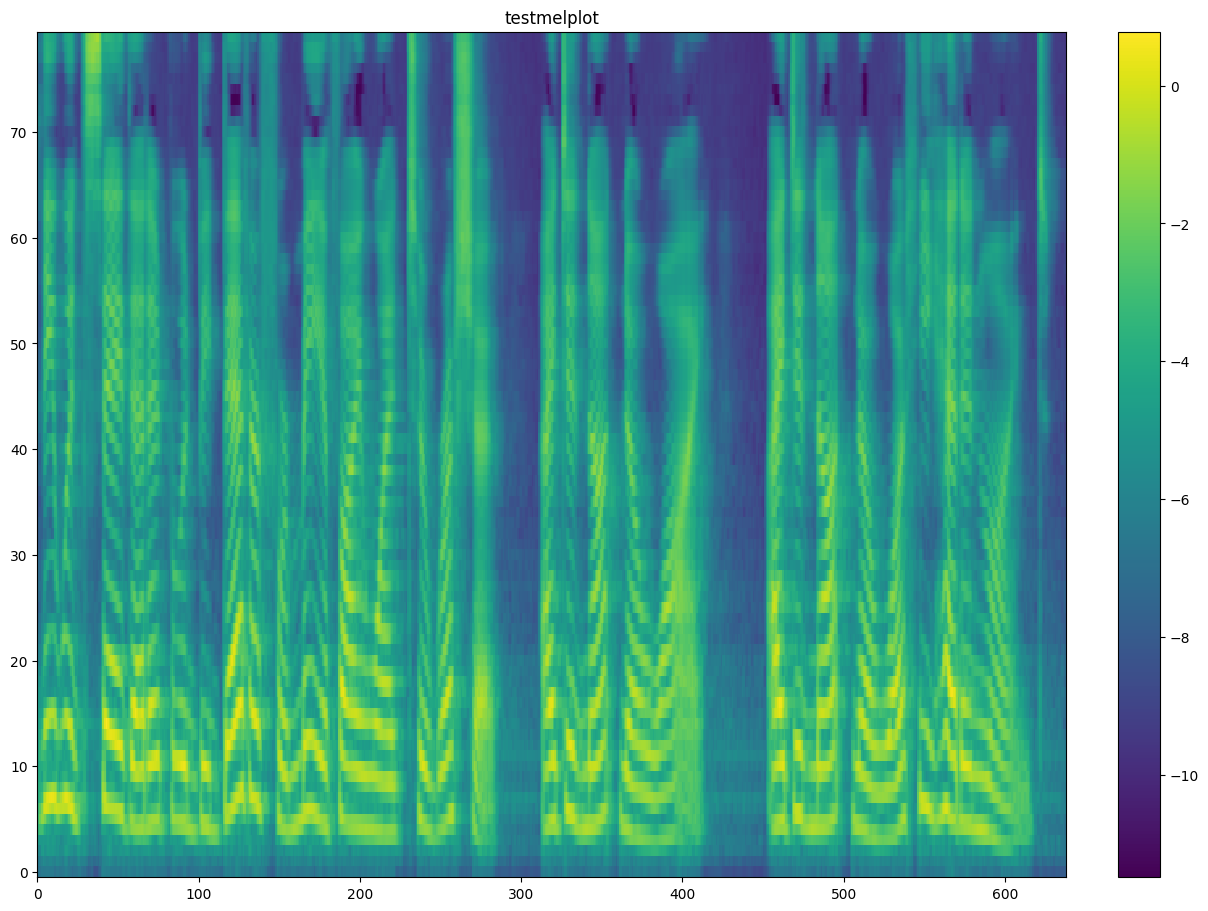

In [36]:
plot_mel([mel4plot], ['testmelplot'])

## [seq] save text2mel

In [37]:
infer_data_num: int = 100 #len(test_ds_list) is 200
print(infer_data_num)
print(f'RESULT_MEL_DIR_PATH: {RESULT_MEL_DIR_PATH}')

100
RESULT_MEL_DIR_PATH: result4eval/infer4PBL/gradseptts/cpu/mel


In [38]:
eval_RTF_list = []
for i in tqdm(range(infer_data_num)):
    # load txt
    text = test_ds_list[i]['text']
    phonemes, phnid = text2phnid(text, phn2id, 'en')
    phnid_len = torch.tensor(len(phnid), dtype=torch.long).unsqueeze(0).to(device)
    phnid = torch.tensor(phnid).unsqueeze(0).to(device)

    # [seq] synth speech
    # process text to mel
    # mel is [n_mels, n_frame]
    start_time = time.perf_counter()
    _, mel_prediction, _ = model.forward(phnid,
                                        phnid_len,
                                        n_timesteps=N_STEP,
                                        temperature=TEMP,
                                        solver='original')
    end_time = time.perf_counter()
    
    dt = end_time - start_time
    dt4mel = dt * 22050 / ( mel_prediction.shape[-1] * 256)
    print(f'{model_name} RTF: {dt}')
    print(f'{model_name} RTF: {dt4mel}')
    
    # for save mel
    mel4save = mel_prediction.unsqueeze(0) # [batch, channel(freq), n_frame(time)] ex.[1, 80, 619]
    # save
    mel_npy_path =  RESULT_MEL_DIR_PATH / f"{test_ds_list[i]['name']}.npy"
    print(f'test_ds_index_{i}: {mel_npy_path}')
    np.save(mel_npy_path, mel4save.cpu().detach().numpy().copy())
    # save eval_RTF
    #eval_dict = {'name': filename, 'rtf': RTF, 'rtf4mel': RTF4mel ,'utmos': utmos_score}
    eval_RTF_dict = {'name': test_ds_list[i]['name'], 
                     'path': str(mel_npy_path),
                     'RTF': dt,
                     'RTF4mel': dt4mel
                    }
    eval_RTF_list.append(eval_RTF_dict)
    

  1%|▉                                                                                            | 1/100 [00:12<21:00, 12.73s/it]

gradseptts RTF: 12.163677336648107
gradseptts RTF: 1.6218138380000167
test_ds_index_0: result4eval/infer4PBL/gradseptts/cpu/mel/LJ045-0049.npy


  2%|█▊                                                                                           | 2/100 [00:17<12:41,  7.77s/it]

gradseptts RTF: 3.749924457632005
gradseptts RTF: 1.2868188852525166
test_ds_index_1: result4eval/infer4PBL/gradseptts/cpu/mel/LJ017-0027.npy


  3%|██▊                                                                                          | 3/100 [00:20<09:09,  5.66s/it]

gradseptts RTF: 2.45782152377069
gradseptts RTF: 1.365800519131646
test_ds_index_2: result4eval/infer4PBL/gradseptts/cpu/mel/LJ023-0031.npy


  4%|███▋                                                                                         | 4/100 [00:27<09:55,  6.20s/it]

gradseptts RTF: 6.521397286094725
gradseptts RTF: 1.1951197652791614
test_ds_index_3: result4eval/infer4PBL/gradseptts/cpu/mel/LJ032-0046.npy


  5%|████▋                                                                                        | 5/100 [00:35<11:13,  7.09s/it]

gradseptts RTF: 7.9592208145186305
gradseptts RTF: 1.1521849984252612
test_ds_index_4: result4eval/infer4PBL/gradseptts/cpu/mel/LJ030-0026.npy


  6%|█████▌                                                                                       | 6/100 [00:47<13:35,  8.68s/it]

gradseptts RTF: 11.213330553844571
gradseptts RTF: 1.244633631565484
test_ds_index_5: result4eval/infer4PBL/gradseptts/cpu/mel/LJ020-0041.npy


  7%|██████▌                                                                                      | 7/100 [00:59<14:54,  9.62s/it]

gradseptts RTF: 10.791461751796305
gradseptts RTF: 1.2999985338019477
test_ds_index_6: result4eval/infer4PBL/gradseptts/cpu/mel/LJ001-0070.npy


  8%|███████▍                                                                                     | 8/100 [01:04<12:41,  8.28s/it]

gradseptts RTF: 4.844711507670581
gradseptts RTF: 1.1370262340784265
test_ds_index_7: result4eval/infer4PBL/gradseptts/cpu/mel/LJ019-0334.npy


  9%|████████▎                                                                                    | 9/100 [01:08<10:38,  7.01s/it]

gradseptts RTF: 3.6864349460229278
gradseptts RTF: 1.1716716236134335
test_ds_index_8: result4eval/infer4PBL/gradseptts/cpu/mel/LJ022-0152.npy


 10%|█████████▏                                                                                  | 10/100 [01:17<11:24,  7.60s/it]

gradseptts RTF: 8.193333066999912
gradseptts RTF: 1.2359278823291653
test_ds_index_9: result4eval/infer4PBL/gradseptts/cpu/mel/LJ050-0154.npy


 11%|██████████                                                                                  | 11/100 [01:32<14:34,  9.82s/it]

gradseptts RTF: 14.283714830875397
gradseptts RTF: 1.5188846065818022
test_ds_index_10: result4eval/infer4PBL/gradseptts/cpu/mel/LJ016-0045.npy


 12%|███████████                                                                                 | 12/100 [01:40<13:32,  9.23s/it]

gradseptts RTF: 7.335029588080943
gradseptts RTF: 1.2243928840932714
test_ds_index_11: result4eval/infer4PBL/gradseptts/cpu/mel/LJ036-0100.npy


 13%|███████████▉                                                                                | 13/100 [01:50<13:32,  9.34s/it]

gradseptts RTF: 8.844220787286758
gradseptts RTF: 1.3850502014181323
test_ds_index_12: result4eval/infer4PBL/gradseptts/cpu/mel/LJ046-0016.npy


 14%|████████████▉                                                                               | 14/100 [02:01<14:27, 10.09s/it]

gradseptts RTF: 11.26489461120218
gradseptts RTF: 1.3821610475483443
test_ds_index_13: result4eval/infer4PBL/gradseptts/cpu/mel/LJ048-0085.npy


 15%|█████████████▊                                                                              | 15/100 [02:05<11:24,  8.05s/it]

gradseptts RTF: 2.7456949604675174
gradseptts RTF: 1.278348266011587
test_ds_index_14: result4eval/infer4PBL/gradseptts/cpu/mel/LJ050-0197.npy


 16%|██████████████▋                                                                             | 16/100 [02:11<10:29,  7.50s/it]

gradseptts RTF: 5.6874937592074275
gradseptts RTF: 1.1366121428230476
test_ds_index_15: result4eval/infer4PBL/gradseptts/cpu/mel/LJ050-0178.npy


 17%|███████████████▋                                                                            | 17/100 [02:29<14:35, 10.55s/it]

gradseptts RTF: 16.913025055080652
gradseptts RTF: 1.5903563492107686
test_ds_index_16: result4eval/infer4PBL/gradseptts/cpu/mel/LJ043-0079.npy


 18%|████████████████▌                                                                           | 18/100 [02:36<13:07,  9.60s/it]

gradseptts RTF: 6.852953871712089
gradseptts RTF: 1.22971706438193
test_ds_index_17: result4eval/infer4PBL/gradseptts/cpu/mel/LJ050-0207.npy


 19%|█████████████████▍                                                                          | 19/100 [02:51<15:20, 11.37s/it]

gradseptts RTF: 14.940728444606066
gradseptts RTF: 1.454109561279854
test_ds_index_18: result4eval/infer4PBL/gradseptts/cpu/mel/LJ034-0005.npy


 20%|██████████████████▍                                                                         | 20/100 [03:02<14:47, 11.09s/it]

gradseptts RTF: 9.711199247278273
gradseptts RTF: 1.2300777998764127
test_ds_index_19: result4eval/infer4PBL/gradseptts/cpu/mel/LJ031-0151.npy


 21%|███████████████████▎                                                                        | 21/100 [03:07<12:24,  9.43s/it]

gradseptts RTF: 4.973305145278573
gradseptts RTF: 1.136246046640755
test_ds_index_20: result4eval/infer4PBL/gradseptts/cpu/mel/LJ023-0021.npy


 22%|████████████████████▏                                                                       | 22/100 [03:16<11:49,  9.09s/it]

gradseptts RTF: 7.796609646640718
gradseptts RTF: 1.218772988801808
test_ds_index_21: result4eval/infer4PBL/gradseptts/cpu/mel/LJ015-0301.npy


 23%|█████████████████████▏                                                                      | 23/100 [03:20<09:43,  7.58s/it]

gradseptts RTF: 3.331966801546514
gradseptts RTF: 1.2058473603942463
test_ds_index_22: result4eval/infer4PBL/gradseptts/cpu/mel/LJ021-0153.npy


 24%|██████████████████████                                                                      | 24/100 [03:24<08:23,  6.63s/it]

gradseptts RTF: 3.8474390069022775
gradseptts RTF: 1.1709920232745585
test_ds_index_23: result4eval/infer4PBL/gradseptts/cpu/mel/LJ014-0037.npy


 25%|███████████████████████                                                                     | 25/100 [03:35<09:54,  7.93s/it]

gradseptts RTF: 10.43406654894352
gradseptts RTF: 1.216123812818233
test_ds_index_24: result4eval/infer4PBL/gradseptts/cpu/mel/LJ004-0200.npy


 26%|███████████████████████▉                                                                    | 26/100 [03:40<08:42,  7.06s/it]

gradseptts RTF: 4.299263502471149
gradseptts RTF: 1.190699862207205
test_ds_index_25: result4eval/infer4PBL/gradseptts/cpu/mel/LJ049-0010.npy


 27%|████████████████████████▊                                                                   | 27/100 [03:44<07:25,  6.10s/it]

gradseptts RTF: 3.3256305111572146
gradseptts RTF: 1.2035542405957291
test_ds_index_26: result4eval/infer4PBL/gradseptts/cpu/mel/LJ008-0291.npy


 28%|█████████████████████████▊                                                                  | 28/100 [03:50<07:17,  6.07s/it]

gradseptts RTF: 5.457639668136835
gradseptts RTF: 1.1354634160101262
test_ds_index_27: result4eval/infer4PBL/gradseptts/cpu/mel/LJ048-0221.npy


 29%|██████████████████████████▋                                                                 | 29/100 [03:57<07:18,  6.17s/it]

gradseptts RTF: 5.642930638976395
gradseptts RTF: 1.157241634946331
test_ds_index_28: result4eval/infer4PBL/gradseptts/cpu/mel/LJ004-0157.npy


 30%|███████████████████████████▌                                                                | 30/100 [04:03<07:15,  6.23s/it]

gradseptts RTF: 5.795797440223396
gradseptts RTF: 1.1691061691024396
test_ds_index_29: result4eval/infer4PBL/gradseptts/cpu/mel/LJ013-0175.npy


 31%|████████████████████████████▌                                                               | 31/100 [04:11<07:57,  6.92s/it]

gradseptts RTF: 7.978354279883206
gradseptts RTF: 1.2293346927508992
test_ds_index_30: result4eval/infer4PBL/gradseptts/cpu/mel/LJ021-0100.npy


 32%|█████████████████████████████▍                                                              | 32/100 [04:19<08:04,  7.13s/it]

gradseptts RTF: 7.063596135005355
gradseptts RTF: 1.2291058615598807
test_ds_index_31: result4eval/infer4PBL/gradseptts/cpu/mel/LJ018-0132.npy


 33%|██████████████████████████████▎                                                             | 33/100 [04:33<10:08,  9.08s/it]

gradseptts RTF: 12.886408315040171
gradseptts RTF: 1.4938662061881507
test_ds_index_32: result4eval/infer4PBL/gradseptts/cpu/mel/LJ023-0059.npy


 34%|███████████████████████████████▎                                                            | 34/100 [04:42<10:07,  9.20s/it]

gradseptts RTF: 8.946555374190211
gradseptts RTF: 1.301675636091204
test_ds_index_33: result4eval/infer4PBL/gradseptts/cpu/mel/LJ003-0027.npy


 35%|████████████████████████████████▏                                                           | 35/100 [04:49<09:21,  8.64s/it]

gradseptts RTF: 6.7874826258048415
gradseptts RTF: 1.2465351137642986
test_ds_index_34: result4eval/infer4PBL/gradseptts/cpu/mel/LJ018-0133.npy


 36%|█████████████████████████████████                                                           | 36/100 [04:56<08:40,  8.13s/it]

gradseptts RTF: 6.2231554025784135
gradseptts RTF: 1.2379165760938764
test_ds_index_35: result4eval/infer4PBL/gradseptts/cpu/mel/LJ033-0060.npy


 37%|██████████████████████████████████                                                          | 37/100 [05:07<09:09,  8.72s/it]

gradseptts RTF: 9.533649308606982
gradseptts RTF: 1.291132120029874
test_ds_index_36: result4eval/infer4PBL/gradseptts/cpu/mel/LJ003-0299.npy


 38%|██████████████████████████████████▉                                                         | 38/100 [05:18<09:50,  9.52s/it]

gradseptts RTF: 10.855369659140706
gradseptts RTF: 1.2968148675020186
test_ds_index_37: result4eval/infer4PBL/gradseptts/cpu/mel/LJ011-0060.npy


 39%|███████████████████████████████████▉                                                        | 39/100 [05:25<08:52,  8.73s/it]

gradseptts RTF: 6.146591533906758
gradseptts RTF: 1.124040798522459
test_ds_index_38: result4eval/infer4PBL/gradseptts/cpu/mel/LJ013-0240.npy


 40%|████████████████████████████████████▊                                                       | 40/100 [05:41<11:04, 11.08s/it]

gradseptts RTF: 16.016442990861833
gradseptts RTF: 1.5011330588126675
test_ds_index_39: result4eval/infer4PBL/gradseptts/cpu/mel/LJ047-0076.npy


 41%|█████████████████████████████████████▋                                                      | 41/100 [05:51<10:28, 10.65s/it]

gradseptts RTF: 9.114732171408832
gradseptts RTF: 1.1328679900543648
test_ds_index_40: result4eval/infer4PBL/gradseptts/cpu/mel/LJ041-0133.npy


 42%|██████████████████████████████████████▋                                                     | 42/100 [06:01<09:59, 10.34s/it]

gradseptts RTF: 8.889760767109692
gradseptts RTF: 1.1178103610559347
test_ds_index_41: result4eval/infer4PBL/gradseptts/cpu/mel/LJ038-0264.npy


 43%|███████████████████████████████████████▌                                                    | 43/100 [06:06<08:21,  8.80s/it]

gradseptts RTF: 4.6490326672792435
gradseptts RTF: 1.1506731581526952
test_ds_index_42: result4eval/infer4PBL/gradseptts/cpu/mel/LJ011-0016.npy


 44%|████████████████████████████████████████▍                                                   | 44/100 [06:15<08:20,  8.93s/it]

gradseptts RTF: 8.684285327792168
gradseptts RTF: 1.1180895662708876
test_ds_index_43: result4eval/infer4PBL/gradseptts/cpu/mel/LJ003-0185.npy


 45%|█████████████████████████████████████████▍                                                  | 45/100 [06:23<07:52,  8.59s/it]

gradseptts RTF: 6.926484510302544
gradseptts RTF: 1.134215953631261
test_ds_index_44: result4eval/infer4PBL/gradseptts/cpu/mel/LJ014-0063.npy


 46%|██████████████████████████████████████████▎                                                 | 46/100 [06:29<07:08,  7.94s/it]

gradseptts RTF: 5.854861626401544
gradseptts RTF: 1.1461265879097482
test_ds_index_45: result4eval/infer4PBL/gradseptts/cpu/mel/LJ005-0185.npy


 47%|███████████████████████████████████████████▏                                                | 47/100 [06:37<06:52,  7.79s/it]

gradseptts RTF: 6.892156472429633
gradseptts RTF: 1.1482414335791935
test_ds_index_46: result4eval/infer4PBL/gradseptts/cpu/mel/LJ014-0135.npy


 48%|████████████████████████████████████████████▏                                               | 48/100 [06:47<07:18,  8.44s/it]

gradseptts RTF: 9.43184384610504
gradseptts RTF: 1.22164095868548
test_ds_index_47: result4eval/infer4PBL/gradseptts/cpu/mel/LJ009-0046.npy


 49%|█████████████████████████████████████████████                                               | 49/100 [07:04<09:19, 10.96s/it]

gradseptts RTF: 16.112103121355176
gradseptts RTF: 1.4810893886151015
test_ds_index_48: result4eval/infer4PBL/gradseptts/cpu/mel/LJ037-0024.npy


 50%|██████████████████████████████████████████████                                              | 50/100 [07:14<08:55, 10.71s/it]

gradseptts RTF: 9.548999012447894
gradseptts RTF: 1.2518754056344894
test_ds_index_49: result4eval/infer4PBL/gradseptts/cpu/mel/LJ002-0217.npy


 51%|██████████████████████████████████████████████▉                                             | 51/100 [07:21<07:57,  9.75s/it]

gradseptts RTF: 6.952634363435209
gradseptts RTF: 1.1472221302812675
test_ds_index_50: result4eval/infer4PBL/gradseptts/cpu/mel/LJ044-0017.npy


 52%|███████████████████████████████████████████████▊                                            | 52/100 [07:27<06:45,  8.45s/it]

gradseptts RTF: 4.695094081573188
gradseptts RTF: 1.168790919647408
test_ds_index_51: result4eval/infer4PBL/gradseptts/cpu/mel/LJ017-0074.npy


 53%|████████████████████████████████████████████████▊                                           | 53/100 [07:33<06:12,  7.93s/it]

gradseptts RTF: 6.159727086313069
gradseptts RTF: 1.158416196892085
test_ds_index_52: result4eval/infer4PBL/gradseptts/cpu/mel/LJ033-0153.npy


 54%|█████████████████████████████████████████████████▋                                          | 54/100 [07:43<06:28,  8.45s/it]

gradseptts RTF: 9.145461476407945
gradseptts RTF: 1.2424673794533418
test_ds_index_53: result4eval/infer4PBL/gradseptts/cpu/mel/LJ032-0124.npy


 55%|██████████████████████████████████████████████████▌                                         | 55/100 [07:49<05:41,  7.60s/it]

gradseptts RTF: 4.8530070427805185
gradseptts RTF: 1.1807998465451806
test_ds_index_54: result4eval/infer4PBL/gradseptts/cpu/mel/LJ018-0287.npy


 56%|███████████████████████████████████████████████████▌                                        | 56/100 [07:55<05:12,  7.11s/it]

gradseptts RTF: 5.41480031888932
gradseptts RTF: 1.1630722708025785
test_ds_index_55: result4eval/infer4PBL/gradseptts/cpu/mel/LJ020-0038.npy


 57%|████████████████████████████████████████████████████▍                                       | 57/100 [08:05<05:47,  8.08s/it]

gradseptts RTF: 9.795004734769464
gradseptts RTF: 1.2156647064214847
test_ds_index_56: result4eval/infer4PBL/gradseptts/cpu/mel/LJ001-0007.npy


 58%|█████████████████████████████████████████████████████▎                                      | 58/100 [08:17<06:30,  9.31s/it]

gradseptts RTF: 11.429147915914655
gradseptts RTF: 1.2492698660866024
test_ds_index_57: result4eval/infer4PBL/gradseptts/cpu/mel/LJ003-0313.npy


 59%|██████████████████████████████████████████████████████▎                                     | 59/100 [08:23<05:45,  8.43s/it]

gradseptts RTF: 5.814533925615251
gradseptts RTF: 1.138232182704335
test_ds_index_58: result4eval/infer4PBL/gradseptts/cpu/mel/LJ019-0265.npy


 60%|███████████████████████████████████████████████████████▏                                    | 60/100 [08:33<05:54,  8.87s/it]

gradseptts RTF: 9.342099816538393
gradseptts RTF: 1.152809931023189
test_ds_index_59: result4eval/infer4PBL/gradseptts/cpu/mel/LJ038-0281.npy


 61%|████████████████████████████████████████████████████████                                    | 61/100 [08:43<05:54,  9.10s/it]

gradseptts RTF: 8.863277981057763
gradseptts RTF: 1.1276500154768492
test_ds_index_60: result4eval/infer4PBL/gradseptts/cpu/mel/LJ045-0235.npy


 62%|█████████████████████████████████████████████████████████                                   | 62/100 [08:46<04:40,  7.37s/it]

gradseptts RTF: 2.7788040060549974
gradseptts RTF: 1.3297011357099109
test_ds_index_61: result4eval/infer4PBL/gradseptts/cpu/mel/LJ038-0255.npy


 63%|█████████████████████████████████████████████████████████▉                                  | 63/100 [08:55<04:43,  7.65s/it]

gradseptts RTF: 7.7520995158702135
gradseptts RTF: 1.1453004015125041
test_ds_index_62: result4eval/infer4PBL/gradseptts/cpu/mel/LJ028-0205.npy


 64%|██████████████████████████████████████████████████████████▉                                 | 64/100 [09:05<05:06,  8.50s/it]

gradseptts RTF: 9.954635806381702
gradseptts RTF: 1.1493576131593317
test_ds_index_63: result4eval/infer4PBL/gradseptts/cpu/mel/LJ014-0260.npy


 65%|███████████████████████████████████████████████████████████▊                                | 65/100 [09:15<05:07,  8.80s/it]

gradseptts RTF: 8.746219722554088
gradseptts RTF: 1.139692138345769
test_ds_index_64: result4eval/infer4PBL/gradseptts/cpu/mel/LJ033-0166.npy


 66%|████████████████████████████████████████████████████████████▋                               | 66/100 [09:24<05:08,  9.08s/it]

gradseptts RTF: 9.178670325316489
gradseptts RTF: 1.134267848105881
test_ds_index_65: result4eval/infer4PBL/gradseptts/cpu/mel/LJ037-0125.npy


 67%|█████████████████████████████████████████████████████████████▋                              | 67/100 [09:31<04:37,  8.41s/it]

gradseptts RTF: 6.317111691460013
gradseptts RTF: 1.135930264847773
test_ds_index_66: result4eval/infer4PBL/gradseptts/cpu/mel/LJ013-0142.npy


 68%|██████████████████████████████████████████████████████████████▌                             | 68/100 [09:44<05:14,  9.83s/it]

gradseptts RTF: 12.418468718416989
gradseptts RTF: 1.2168801338572535
test_ds_index_67: result4eval/infer4PBL/gradseptts/cpu/mel/LJ031-0199.npy


 69%|███████████████████████████████████████████████████████████████▍                            | 69/100 [09:51<04:35,  8.89s/it]

gradseptts RTF: 6.133609022945166
gradseptts RTF: 1.1410475073901603
test_ds_index_68: result4eval/infer4PBL/gradseptts/cpu/mel/LJ004-0017.npy


 70%|████████████████████████████████████████████████████████████████▍                           | 70/100 [10:01<04:33,  9.12s/it]

gradseptts RTF: 9.11508076544851
gradseptts RTF: 1.1361903654019292
test_ds_index_69: result4eval/infer4PBL/gradseptts/cpu/mel/LJ024-0115.npy


 71%|█████████████████████████████████████████████████████████████████▎                          | 71/100 [10:06<03:54,  8.07s/it]

gradseptts RTF: 4.893983134999871
gradseptts RTF: 1.1709236992919614
test_ds_index_70: result4eval/infer4PBL/gradseptts/cpu/mel/LJ017-0171.npy


 72%|██████████████████████████████████████████████████████████████████▏                         | 72/100 [10:11<03:16,  7.01s/it]

gradseptts RTF: 3.9918457651510835
gradseptts RTF: 1.1938503570092962
test_ds_index_71: result4eval/infer4PBL/gradseptts/cpu/mel/LJ017-0040.npy


 73%|███████████████████████████████████████████████████████████████████▏                        | 73/100 [10:18<03:10,  7.07s/it]

gradseptts RTF: 6.67520896345377
gradseptts RTF: 1.1453277331623166
test_ds_index_72: result4eval/infer4PBL/gradseptts/cpu/mel/LJ005-0044.npy


 74%|████████████████████████████████████████████████████████████████████                        | 74/100 [10:22<02:42,  6.24s/it]

gradseptts RTF: 3.5532381841912866
gradseptts RTF: 1.2340741866402765
test_ds_index_73: result4eval/infer4PBL/gradseptts/cpu/mel/LJ007-0169.npy


 75%|█████████████████████████████████████████████████████████████████████                       | 75/100 [10:33<03:12,  7.71s/it]

gradseptts RTF: 10.598808972164989
gradseptts RTF: 1.2204615319823593
test_ds_index_74: result4eval/infer4PBL/gradseptts/cpu/mel/LJ015-0153.npy


 76%|█████████████████████████████████████████████████████████████████████▉                      | 76/100 [10:45<03:31,  8.80s/it]

gradseptts RTF: 10.815101755782962
gradseptts RTF: 1.2338213664891056
test_ds_index_75: result4eval/infer4PBL/gradseptts/cpu/mel/LJ045-0043.npy


 77%|██████████████████████████████████████████████████████████████████████▊                     | 77/100 [10:54<03:25,  8.94s/it]

gradseptts RTF: 8.479592902585864
gradseptts RTF: 1.1358805374102006
test_ds_index_76: result4eval/infer4PBL/gradseptts/cpu/mel/LJ050-0010.npy


 78%|███████████████████████████████████████████████████████████████████████▊                    | 78/100 [11:04<03:20,  9.09s/it]

gradseptts RTF: 8.889705989509821
gradseptts RTF: 1.1310123769196105
test_ds_index_77: result4eval/infer4PBL/gradseptts/cpu/mel/LJ006-0126.npy


 79%|████████████████████████████████████████████████████████████████████████▋                   | 79/100 [11:13<03:11,  9.12s/it]

gradseptts RTF: 8.647906654514372
gradseptts RTF: 1.1320190309890406
test_ds_index_78: result4eval/infer4PBL/gradseptts/cpu/mel/LJ018-0356.npy


 80%|█████████████████████████████████████████████████████████████████████████▌                  | 80/100 [11:22<03:02,  9.13s/it]

gradseptts RTF: 8.592168011702597
gradseptts RTF: 1.1385655328007347
test_ds_index_79: result4eval/infer4PBL/gradseptts/cpu/mel/LJ040-0223.npy


 81%|██████████████████████████████████████████████████████████████████████████▌                 | 81/100 [11:29<02:39,  8.40s/it]

gradseptts RTF: 5.980185615830123
gradseptts RTF: 1.168005003091821
test_ds_index_80: result4eval/infer4PBL/gradseptts/cpu/mel/LJ008-0281.npy


 82%|███████████████████████████████████████████████████████████████████████████▍                | 82/100 [11:34<02:15,  7.53s/it]

gradseptts RTF: 4.967419077642262
gradseptts RTF: 1.1754334506139668
test_ds_index_81: result4eval/infer4PBL/gradseptts/cpu/mel/LJ008-0222.npy


 83%|████████████████████████████████████████████████████████████████████████████▎               | 83/100 [11:44<02:20,  8.28s/it]

gradseptts RTF: 9.490673155523837
gradseptts RTF: 1.1465054297384543
test_ds_index_82: result4eval/infer4PBL/gradseptts/cpu/mel/LJ046-0123.npy


 84%|█████████████████████████████████████████████████████████████████████████████▎              | 84/100 [11:53<02:17,  8.58s/it]

gradseptts RTF: 8.557714295573533
gradseptts RTF: 1.1357473048523954
test_ds_index_83: result4eval/infer4PBL/gradseptts/cpu/mel/LJ030-0044.npy


 85%|██████████████████████████████████████████████████████████████████████████████▏             | 85/100 [12:02<02:07,  8.52s/it]

gradseptts RTF: 7.834368308074772
gradseptts RTF: 1.1341112210678095
test_ds_index_84: result4eval/infer4PBL/gradseptts/cpu/mel/LJ018-0051.npy


 86%|███████████████████████████████████████████████████████████████████████████████             | 86/100 [12:08<01:48,  7.73s/it]

gradseptts RTF: 5.341222112067044
gradseptts RTF: 1.158827412341372
test_ds_index_85: result4eval/infer4PBL/gradseptts/cpu/mel/LJ042-0231.npy


 87%|████████████████████████████████████████████████████████████████████████████████            | 87/100 [12:20<01:57,  9.03s/it]

gradseptts RTF: 11.364037282764912
gradseptts RTF: 1.2964456854561583
test_ds_index_86: result4eval/infer4PBL/gradseptts/cpu/mel/LJ011-0121.npy


 88%|████████████████████████████████████████████████████████████████████████████████▉           | 88/100 [12:27<01:42,  8.55s/it]

gradseptts RTF: 6.8586506973952055
gradseptts RTF: 1.1538181143002646
test_ds_index_87: result4eval/infer4PBL/gradseptts/cpu/mel/LJ016-0186.npy


 89%|█████████████████████████████████████████████████████████████████████████████████▉          | 89/100 [12:38<01:40,  9.16s/it]

gradseptts RTF: 10.061391775496304
gradseptts RTF: 1.2205858750533314
test_ds_index_88: result4eval/infer4PBL/gradseptts/cpu/mel/LJ011-0164.npy


 90%|██████████████████████████████████████████████████████████████████████████████████▊         | 90/100 [12:49<01:37,  9.76s/it]

gradseptts RTF: 10.39122493751347
gradseptts RTF: 1.2277440729604554
test_ds_index_89: result4eval/infer4PBL/gradseptts/cpu/mel/LJ026-0039.npy


 91%|███████████████████████████████████████████████████████████████████████████████████▋        | 91/100 [12:59<01:29,  9.91s/it]

gradseptts RTF: 9.71329640597105
gradseptts RTF: 1.1969006267416715
test_ds_index_90: result4eval/infer4PBL/gradseptts/cpu/mel/LJ003-0105.npy


 92%|████████████████████████████████████████████████████████████████████████████████████▋       | 92/100 [13:04<01:07,  8.43s/it]

gradseptts RTF: 4.4306424064561725
gradseptts RTF: 1.2000745020435166
test_ds_index_91: result4eval/infer4PBL/gradseptts/cpu/mel/LJ039-0104.npy


 93%|█████████████████████████████████████████████████████████████████████████████████████▌      | 93/100 [13:11<00:56,  8.03s/it]

gradseptts RTF: 6.331874147057533
gradseptts RTF: 1.1433587603398405
test_ds_index_92: result4eval/infer4PBL/gradseptts/cpu/mel/LJ002-0038.npy


 94%|██████████████████████████████████████████████████████████████████████████████████████▍     | 94/100 [13:23<00:54,  9.09s/it]

gradseptts RTF: 11.023693659342825
gradseptts RTF: 1.2235847152288846
test_ds_index_93: result4eval/infer4PBL/gradseptts/cpu/mel/LJ046-0194.npy


 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 95/100 [13:31<00:44,  8.88s/it]

gradseptts RTF: 7.825152013450861
gradseptts RTF: 1.13277706077069
test_ds_index_94: result4eval/infer4PBL/gradseptts/cpu/mel/LJ008-0115.npy


 96%|████████████████████████████████████████████████████████████████████████████████████████▎   | 96/100 [13:36<00:30,  7.72s/it]

gradseptts RTF: 4.485873530618846
gradseptts RTF: 1.1925336534305744
test_ds_index_95: result4eval/infer4PBL/gradseptts/cpu/mel/LJ016-0104.npy


 97%|█████████████████████████████████████████████████████████████████████████████████████████▏  | 97/100 [13:46<00:24,  8.31s/it]

gradseptts RTF: 8.950006874278188
gradseptts RTF: 1.1386842894769782
test_ds_index_96: result4eval/infer4PBL/gradseptts/cpu/mel/LJ019-0301.npy


 98%|██████████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [13:58<00:18,  9.43s/it]

gradseptts RTF: 11.492383080534637
gradseptts RTF: 1.2342534626606763
test_ds_index_97: result4eval/infer4PBL/gradseptts/cpu/mel/LJ028-0012.npy


 99%|███████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [14:08<00:09,  9.54s/it]

gradseptts RTF: 9.26639626454562
gradseptts RTF: 1.1418322918523722
test_ds_index_98: result4eval/infer4PBL/gradseptts/cpu/mel/LJ018-0059.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:26<00:00,  8.67s/it]

gradseptts RTF: 17.629099347628653
gradseptts RTF: 1.4785237669456388
test_ds_index_99: result4eval/infer4PBL/gradseptts/cpu/mel/LJ029-0081.npy


In [39]:
print(eval_RTF_list[99])
print(len(eval_RTF_list))

{'name': 'LJ029-0081', 'path': 'result4eval/infer4PBL/gradseptts/cpu/mel/LJ029-0081.npy', 'RTF': 17.629099347628653, 'RTF4mel': 1.4785237669456388}
100


In [42]:
print('fin')

fin


In [43]:
RESULT_JSON_PATH = RESULT_DIR_PATH / 'evalRTF4PBL.json'
if RESULT_JSON_PATH.exists() == False:
    with open(RESULT_JSON_PATH, 'w') as f:
        for entry in eval_RTF_list:
            f.write(json.dumps(entry) + '\n')
    print(f'Make {RESULT_JSON_PATH}')
else:
    print(f'Already Exists {RESULT_JSON_PATH}')

Already Exists result4eval/infer4PBL/gradseptts/cpu/evalRTF4PBL.json


## show result RTF

In [44]:
eval_target = 'gradseptts_cpu'

eval_info = {
    'gradtts_cuda': 'result4eval/infer4PBL/gradtts/cuda/evalRTF4PBL.json',
    'gradtts_cpu': 'result4eval/infer4PBL/gradtts/cpu/evalRTF4PBL.json',
    'gradseptts_cuda': 'result4eval/infer4PBL/gradseptts/cuda/evalRTF4PBL.json',
    'gradseptts_cpu': 'result4eval/infer4PBL/gradseptts/cpu/evalRTF4PBL.json',
    'gradtfktts_cuda': 'result4eval/infer4PBL/gradtfktts/cuda/evalRTF4PBL.json',
    'gradtfktts_cpu': 'result4eval/infer4PBL/gradtfktts/cpu/evalRTF4PBL.json'
}

eval_jsonl_path = Path(eval_info[eval_target])
if eval_jsonl_path.exists() == True:
    print(f'Exist {eval_jsonl_path}')
    import json
    with open(eval_jsonl_path) as f:
        eval_jsonl_list = [json.loads(l) for l in f]
else:
    print(f'No Exists {eval_jsonl_path}')

Exist result4eval/infer4PBL/gradseptts/cpu/evalRTF4PBL.json


In [45]:
# culc for RTF
RTF_list = [eval_jsonl_list[n]['RTF'] for n in range(len(eval_jsonl_list))]
RTF_nparr = np.array(RTF_list)
RTF_mean = np.mean(RTF_nparr)
RTF_var = np.var(RTF_nparr)
RTF_std = np.std(RTF_nparr)
print(f'RTF mean: {RTF_mean}')
print(f'RTF var: {RTF_var}')
print(f'RTF std: {RTF_std}')

RTF mean: 8.05599136098288
RTF var: 10.092437268497742
RTF std: 3.176859655146532


In [46]:
RTF_nparr.max()

np.float64(17.629099347628653)

## [seq] plot mel

In [1]:
# test plot
"""
x = np.load(IMEL_DIR_PATH / f"{test_ds_list[0]['name']}.npy") # [1, n_mel, n_frame]
x4plot = torch.FloatTensor(x).to(device)
x4plot = x4plot.squeeze(0).cpu()
print(x4plot.shape)
fig_meltmp = plot_mel([x4plot], ['mel2wavtmp'])
"""

NameError: name 'np' is not defined